In [1]:
import warnings
warnings.simplefilter(action='ignore')

import numpy as np
import pandas as pd

import pickle
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

from tensorflow import keras
import matplotlib

2023-12-10 23:09:07.216903: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [102]:
file_names = ['lc_classnum_Ia-norm_90.pickle', 
 'lc_classnum_Ia-91bg_67.pickle', 
 'lc_classnum_Iax_52.pickle', 
'lc_classnum_Ib.pickle', 
 'lc_classnum_Ic.pickle',  
 'lc_classnum_Ic-BL.pickle',  
 'lc_classnum_II.pickle', 
 'lc_classnum_IIn.pickle', 
 'lc_classnum_IIb.pickle', 
 'lc_classnum_TDE_64.pickle', 
 'lc_classnum_SLSN-I_60.pickle', 
 'lc_classnum_AGN_70_old.pickle',
 'lc_classnum_CART_63_old.pickle',
 'lc_classnum_Kilonova_99.pickle',
'lc_classnum_PISN_61_old.pickle',
'lc_classnum_ILOT_62_old.pickle',
'lc_classnum_uLens-BSR_90_old.pickle']

classes = ['SNIa', 'SNIa-91bg', 'SNIax', 'SNIb', 'SNIc', 'SNIc-BL', 'SNII', 'SNIIn', 'SNIIb', 'TDE', 'SLSN-I', 'AGN', 'CaRT', 'PISN', 'KNe', 'ILOT', 'uLens-BSR']

file_to_class = dict(zip(file_names, classes))

anom_classes = file_names[-5:]
non_anom_classes = file_names[:-5]


color = ['r', 'g', 'y', 'b', 'pink', 'orange', 'gray', 'k', 'm', 'c', 'brown', 'olive']
colors = color

font = {'size'   : 15}

matplotlib.rc('font', **font)

In [105]:
full_data = []

for filename in file_names:
  data = pickle.load(open(f"./saved_light_curves_newsims/{filename}", "rb"))
  full_data.append(data)


In [117]:
# Plot cadence distributions
mean_cadences = {}
for class_num in range(len(file_names)):

    mean_cadences[class_num] = []
    for key, value in full_data[class_num].items():
        full_data[class_num][key].sort("time")
        mean_cad = np.mean(np.diff(full_data[class_num][key]['time']))
        mean_cadences[class_num].append(mean_cad)
        if (len(mean_cadences) == 13000):
            break
    mean_cadences[class_num] = np.asarray(mean_cadences[class_num])

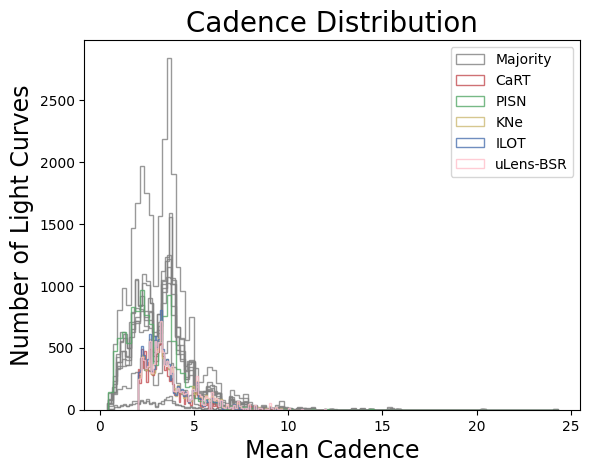

In [119]:
# plt.figure(figsize=(8, 8))
plt.style.use('default')
for class_num in range(len(file_names)):
    # print(np.array(mean_cadences[class_num]).shape)

    plt.hist(mean_cadences[class_num], bins=100, label='Majority' if file_to_class[file_names[class_num]] == 'SNIa' else file_to_class[file_names[class_num]] if file_names[class_num] in anom_classes else None, alpha=0.8, histtype='step', color = colors[anom_classes.index(file_names[class_num])] if file_names[class_num] in anom_classes else 'gray')
    

plt.xlabel('Mean Cadence', fontsize=17)
plt.ylabel('Number of Light Curves', fontsize=17)
plt.legend()
# plt.xlim(0, 10)

plt.title("Cadence Distribution", fontsize=20)

plt.savefig("FiguresNew/cadencedist.pdf", bbox_inches='tight')


In [113]:
# plt.figure(figsize=(8, 8))
plt.style.use('default')
for class_num in file_names:
    # print(np.array(mean_cadences[class_num]).shape)
    plt.hist(mean_cadences[class_num], bins=100, label='Majority' if file_to_class[class_num] == 'SNIa' else file_to_class[class_num] if class_num in anom_classes else None, alpha=0.8, histtype='step', color = colors[anom_classes.index(class_num)] if file_to_class in anom_classes else 'gray')
    

plt.xlabel('Mean Cadence', fontsize=17)
plt.ylabel('Number of Light Curves', fontsize=17)
plt.legend()
# plt.xlim(0, 10)

plt.title("Cadence Distribution", fontsize=20)

plt.savefig("Figures/cadencedist", bbox_inches='tight')


KeyError: 'lc_classnum_Ia-norm_90.pickle'

In [ ]:
mx = 0
mn = 1e9

for ind, filename in enumerate(file_names):

  data = full_data[ind]
  ids = list(data.keys())
  for id in ids[:10]:

    df = (pd.DataFrame(np.array(data[id])))

    print(np.max(df['flux'])/500, np.min(df['flux'])/500)


In [ ]:
x_data = [] # shape => for each time step, store time, median passband wavelength, flux, flux error
host_galaxy_info = []
target = [] # store target class

In [ ]:
import os

band_medians = {'r' : 0.4827, 'g' : 0.6223} # Median Wavelength (in Angstroms) Scaled over 10000 for ZTF


before = 30
after = 70

for ind, filename in enumerate(file_names):

  data = full_data[ind]

  ids = list(data.keys())

  for id in ids:

    df = data[id]
    df = pd.DataFrame(np.array(df))
    
    cur_meta = [data[id].meta['redshift'], data[id].meta['mwebv']] # host gal info, redshift and extinction

    df['flux'] = (df['flux']) / 500
    df['fluxErr'] = (df['fluxErr']) / 500

    trigger_mjd = 0

    df = df[(df['time'] > trigger_mjd - before) & (df['time'] < trigger_mjd + after)] # Scale Time

    
    if (len(df) == 0):
        continue
#     if (len(df[df['time'] < 0]) < 2):
#       continue

    df.sort_values("time", inplace=True)
    df.drop('photflag', axis=1, inplace=True)

    df.time = (df.time - (-before)) / (after + before)


    df['passband'] = df['passband'].map(band_medians)

    x_data.append(np.array(df))
    target.append(filename)
    host_galaxy_info.append(cur_meta)
    
  print(ind)


In [3]:
def save(file_name , obj):
    with open(file_name, 'wb') as f:
        pickle.dump(obj, f)

In [ ]:

        
save("target", target)
save("x_data", x_data)
save("host_galaxy_info", host_galaxy_info)

In [4]:
def load(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

target = load("target")
x_data = load("x_data")
host_galaxy_info = load("host_galaxy_info")


In [5]:
valid = [False] * len(target)

for class_ in np.unique(target):
    cnt = 0
    for i in range(len(target)):
        
        if (target[i] == class_):
            valid[i] = True
            cnt+=1
        if (cnt == 13000):
            break

In [6]:
for i in range(len(target) - 1, -1, -1):
    if not valid[i]:
        del target[i]
        del x_data[i]
        del host_galaxy_info[i]

In [7]:
lengths = []

for lc in x_data:
    lengths.append(len(lc))

ntimesteps = np.max(lengths)

print(ntimesteps)

656


In [8]:
# Pad for TF masking layer



for ind in range(len(x_data)):
  x_data[ind] = np.pad(x_data[ind], ((0, ntimesteps - len(x_data[ind])), (0, 0)))

In [9]:
# Split data

y_data_anom = []
y_data_norm = []
x_data_norm = []
x_data_anom = []
host_gal_anom = []
host_gal = []

for i in range(len(target)):

    if (target[i] in anom_classes):
        x_data_anom.append(x_data[i])
        y_data_anom.append(target[i])
        host_gal_anom.append(host_galaxy_info[i])

    else:
        x_data_norm.append(x_data[i])
        y_data_norm.append(target[i])
        host_gal.append(host_galaxy_info[i])



In [10]:
# print(np.unique(y_train, return_counts=True))

In [11]:
# One-hot Encoding

from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')

y_data_norm = enc.fit_transform(np.array(y_data_norm).reshape(-1, 1)).todense()

In [12]:
# Train-test split

X_train, X_test, host_gal_train, host_gal_test, y_train, y_test = train_test_split(x_data_norm, host_gal, y_data_norm, random_state = 40, test_size = 0.1)


In [13]:
X_train, X_val, host_gal_train, host_gal_val, y_train, y_val = train_test_split(X_train, host_gal_train, y_train, random_state = 40, test_size = 1/9)

In [14]:
class_weights = {i : 0 for i in range(y_train.shape[1])}

for value in y_train:
  class_weights[np.argmax(value)]+=1

for id in class_weights.keys():
  class_weights[id] = len(y_train) / class_weights[id]


In [15]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

X_test = np.array(X_test)
y_test = np.array(y_test)

host_gal_train = np.array(host_gal_train)
host_gal_test = np.array(host_gal_test)
host_gal_val = np.array(host_gal_val)

In [16]:
dummy = enc.transform(np.array(non_anom_classes).reshape(-1, 1))

ordered_class_names = [-1 for i in range(len(non_anom_classes))]

for ind, i in enumerate(dummy.todense()):
    ordered_class_names[np.argmax(i)] = file_to_class[non_anom_classes[ind]]

In [17]:
train_counts = {i : 0 for i in file_to_class.values()}

for i in y_train:
    train_counts[ordered_class_names[np.argmax(i)]] += 1
    
val_counts = {i : 0 for i in file_to_class.values()}

for i in y_val:
    val_counts[ordered_class_names[np.argmax(i)]] += 1
    
test_counts = {i : 0 for i in file_to_class.values()}

for i in y_test:
    test_counts[ordered_class_names[np.argmax(i)]] += 1

In [18]:


for i in y_data_anom:
    test_counts[file_to_class[i]] += 1

In [19]:
full_data = {i: [] for i in reversed(file_to_class.values())}

for i in train_counts.keys():
    full_data[i].append(train_counts[i])
    
for i in val_counts.keys():
    full_data[i].append(val_counts[i])
    
for i in test_counts.keys():
    full_data[i].append(test_counts[i])

In [20]:
for key, value in reversed(full_data.items()):
    print(f"{key} & {value[0]} & {value[1]} & {value[2]} & {value[1] + value[0] + value[2]} \\\\")
    print("\hline")




SNIa & 10386 & 1325 & 1289 & 13000 \\
\hline
SNIa-91bg & 10389 & 1307 & 1304 & 13000 \\
\hline
SNIax & 10315 & 1315 & 1370 & 13000 \\
\hline
SNIb & 4231 & 529 & 507 & 5267 \\
\hline
SNIc & 1250 & 164 & 169 & 1583 \\
\hline
SNIc-BL & 1130 & 158 & 135 & 1423 \\
\hline
SNII & 10453 & 1285 & 1262 & 13000 \\
\hline
SNIIn & 10403 & 1289 & 1308 & 13000 \\
\hline
SNIIb & 9907 & 1177 & 1239 & 12323 \\
\hline
TDE & 9096 & 1163 & 1095 & 11354 \\
\hline
SLSN-I & 10290 & 1261 & 1329 & 12880 \\
\hline
AGN & 8462 & 1066 & 1033 & 10561 \\
\hline
CaRT & 0 & 0 & 10353 & 10353 \\
\hline
PISN & 0 & 0 & 11166 & 11166 \\
\hline
KNe & 0 & 0 & 10840 & 10840 \\
\hline
ILOT & 0 & 0 & 11128 & 11128 \\
\hline
uLens-BSR & 0 & 0 & 11244 & 11244 \\
\hline


In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, TimeDistributed, Dense, Masking, concatenate, GRU
from tensorflow.keras.callbacks import EarlyStopping
from math import dist

def create_no_redshift(latent_size):

    num_classes = len(class_weights)
    n_features = 4

    input_1 = Input((ntimesteps, n_features), name='lc')  # X.shape = (Nobjects, Ntimesteps, 4)

    masking_input1 = Masking(mask_value=0.)(input_1)

    lstm1 = GRU(100, return_sequences=True, activation='tanh')(masking_input1)
    lstm2 = GRU(100, return_sequences=False, activation='tanh')(lstm1)

    dense1 = Dense(100, activation='tanh')(lstm2)

    input_2 = Input(shape = (1, ), name='host')

    dense2 = Dense(5)(input_2)

    merge1 = concatenate([dense1, dense2])

    dense3 = Dense(100, activation='relu')(merge1)

    dense4 = Dense(latent_size, activation='relu', name='latent')(dense3)

    output = Dense(num_classes, activation='softmax')(dense4)

    model = keras.Model(inputs=[input_1, input_2], outputs=output)

    model.compile(loss = "categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    
    return model

def create_redshift(latent_size):

    num_classes = len(class_weights)
    n_features = 4

    input_1 = Input((ntimesteps, n_features), name='lc')  # X.shape = (Nobjects, Ntimesteps, 4)

    masking_input1 = Masking(mask_value=0.)(input_1)

    lstm1 = GRU(100, return_sequences=True, activation='tanh')(masking_input1)
    lstm2 = GRU(100, return_sequences=False, activation='tanh')(lstm1)

    dense1 = Dense(100, activation='tanh')(lstm2)

    input_2 = Input(shape = (2, ), name='host')

    dense2 = Dense(10)(input_2)

    merge1 = concatenate([dense1, dense2])

    dense3 = Dense(100, activation='relu')(merge1)

    dense4 = Dense(latent_size, activation='relu', name='latent')(dense3)

    output = Dense(num_classes, activation='softmax')(dense4)

    model = keras.Model(inputs=[input_1, input_2], outputs=output)

    model.compile(loss = "categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    
    return model

In [85]:
def dilate(vals, red):
    # return ((((vals * 100) - 30) / (1 + red)) + 30) * 100
    return vals / (1 + red)

X_test_redshift = X_test.copy()

for i in range(len(X_test)):
    X_test_redshift[i][:, 1] = dilate(X_test_redshift[i][:, 1], host_gal_test[i][0])
    
X_train_redshift = X_train.copy()

for i in range(len(X_train)):
    X_train_redshift[i][:, 1] = dilate(X_train_redshift[i][:, 1], host_gal_train[i][0])
    
    
X_val_redshift = X_val.copy()

for i in range(len(X_val)):
    X_val_redshift[i][:, 1] = dilate(X_val_redshift[i][:, 1], host_gal_val[i][0])
    
X_anom_redshift = x_data_anom.copy()

for i in range(len(X_anom_redshift)):
    X_anom_redshift[i][:, 1] = dilate(X_anom_redshift[i][:, 1], host_gal_anom[i][0])
    
x_data_anom = np.array(x_data_anom)
host_gal_anom = np.array(host_gal_anom)

X_anom_redshift = np.array(X_anom_redshift)

In [24]:
from tensorflow.keras import Model
from sklearn.ensemble import IsolationForest
class Trained_Model:
    def __init__(self, size, redshift):
        
        self.size = size
        self.redshift = redshift
        
        
        if (not self.redshift):
            self.X_train = X_train
            self.X_test = X_test
            self.X_val = X_val
            self.X_anom = x_data_anom
            self.host_gal_train = host_gal_train_no
            self.host_gal_test = host_gal_test_no
            self.host_gal_anom = host_gal_anom_no
            self.host_gal_val = host_gal_val_no
            
        else:
            self.X_train = X_train_redshift
            self.X_test = X_test_redshift
            self.X_val = X_val_redshift
            self.X_anom = X_anom_redshift
            self.host_gal_train = host_gal_train
            self.host_gal_test = host_gal_test
            self.host_gal_anom = host_gal_anom
            self.host_gal_val = host_gal_val
            
        
        
        
    def load_model(self):
        ins = 'No' if not self.redshift else ''
        self.model=keras.models.load_model(f'Models/{ins}RedshiftLatent_{self.size}')
        self.latent_model = Model(inputs=[self.model.get_layer('lc').input, self.model.get_layer('host').input], outputs=self.model.get_layer('latent').output)
        
        
    def _train_latent(self):
        print(self.host_gal_train.shape)
        self.train_latent = self.latent_model.predict([self.X_train, self.host_gal_train])
        
    def _test_latent(self):
        self.test_latent = self.latent_model.predict([self.X_test, self.host_gal_test])
        
    def _val_latent(self):
        self.val_latent = self.latent_model.predict([self.X_val, self.host_gal_val])
        
    def _anom_latent(self):
        self.anom_latent = self.latent_model.predict([self.X_anom, self.host_gal_anom])
    
    def initialize_mcif(self):

        self.iso_forests = []
        

        full_latent_data = [[] for i in range(12)]

        for i in range(len(self.train_latent)):
            full_latent_data[np.argmax(y_train[i])].append(self.train_latent[i])
            
        for i in range(len(self.val_latent)):
            full_latent_data[np.argmax(y_val[i])].append(self.val_latent[i])


        for i in range(12):
            self.iso_forests.append(IsolationForest(random_state=0, max_samples = 'auto', n_estimators=200).fit(np.array(full_latent_data[i])))

        # self.iso_forests.append(iso_forests)
        
        
    def score(self, x_data):
        scores = [-det.decision_function(x_data) for det in self.iso_forests]

        scores = np.array(scores)
        scores = scores.T
        return [np.min(i) for i in scores]
    
    def score_val(self):
        self.val_scores = self.score(self.val_latent)
        
    def score_test(self):
        self.test_scores = self.score(self.test_latent)
        
    def score_anom(self):
        self.anom_scores = self.score(self.anom_latent)
        
    def score_train(self):
        self.train_scores = self.score(self.train_latent)
            
        

In [62]:
model = create_redshift(9)

early_stopping = EarlyStopping(
                              patience=5,
                              min_delta=0.001,                               
                              monitor="val_loss",
                              restore_best_weights=True
                              )

try:
    history = model.fit(x = [X_train_redshift, host_gal_train], validation_data=([X_val_redshift, host_gal_val], y_val), y = y_train, epochs=40, batch_size = 128, class_weight = class_weights, callbacks=[early_stopping])
except Exception as e:
    pass

Epoch 1/40


2023-12-10 23:27:38.926544: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT8
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_41/output/_22'
2023-12-10 23:27:39.658958: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc1cc59b430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-10 23:27:39.659014: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla P100-PCIE-12GB, Comp

753/753 [==============================] - 85s 97ms/step - loss: 25.2757 - accuracy: 0.2161 - val_loss: 2.0418 - val_accuracy: 0.2214
Epoch 2/40
753/753 [==============================] - 70s 93ms/step - loss: 24.0142 - accuracy: 0.2331 - val_loss: 1.9609 - val_accuracy: 0.2610
Epoch 3/40
753/753 [==============================] - 70s 93ms/step - loss: 23.9058 - accuracy: 0.2375 - val_loss: 1.9670 - val_accuracy: 0.2434
Epoch 4/40
753/753 [==============================] - 70s 93ms/step - loss: 23.7092 - accuracy: 0.2460 - val_loss: 1.9536 - val_accuracy: 0.2580
Epoch 5/40
753/753 [==============================] - 70s 93ms/step - loss: 23.6155 - accuracy: 0.2497 - val_loss: 1.9741 - val_accuracy: 0.2522
Epoch 6/40
753/753 [==============================] - 70s 93ms/step - loss: 23.5076 - accuracy: 0.2556 - val_loss: 1.9565 - val_accuracy: 0.2535
Epoch 7/40
753/753 [==============================] - 70s 93ms/step - loss: 23.4762 - accuracy: 0.2597 - val_loss: 1.9443 - val_accuracy: 0.2

In [63]:
latent_size=9
model.save(f"Models/RedshiftLatent_{latent_size}Fixed")
save(f"Models/RedshiftLatent_{latent_size}_historyFixed", history)

INFO:tensorflow:Assets written to: Models/RedshiftLatent_9Fixed/assets


INFO:tensorflow:Assets written to: Models/RedshiftLatent_9Fixed/assets


In [87]:
best = (Trained_Model(9, True))

In [88]:


best.load_model()
best.train_latent = best.latent_model.predict([X_train_redshift, host_gal_train])
best.val_latent = best.latent_model.predict([X_val_redshift, host_gal_val])
best.initialize_mcif()
best.anom_latent = best.latent_model.predict([X_anom_redshift, host_gal_anom])

best.score_anom()
best.score_val()

best.test_predictions = best.model.predict([X_test_redshift, host_gal_test])

2023-12-11 00:36:59.056562: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-12-11 00:36:59.367630: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-12-11 00:37:00.072619: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-12-11 00:37:00.433865: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.


377/377 [==============================] - 6s 8ms/step


In [89]:
best.test_latent = best.latent_model.predict([X_test_redshift, host_gal_test])
best.score_test()

377/377 [==============================] - 3s 8ms/step


In [90]:
save("NewFinal", best)

In [34]:
def saveplot(savepath):
    if (savepath):
        plt.savefig(savepath + '.pdf', bbox_inches='tight')

def average_score(scores_maj, y_data_maj, scores_anom, y_data_anom, title="", savepath=None):
    total_counts = {i : 0 for i in file_to_class.values()}
    average_score = {i : 0 for i in file_to_class.values()}


    for i in range(len(y_data_maj)):

        total_counts[file_to_class[non_anom_classes[np.argmax(y_data_maj[i])]]] += 1
        average_score[file_to_class[non_anom_classes[np.argmax(y_data_maj[i])]]] += scores_maj[i]

    for i in range(len(y_data_anom)):
        total_counts[file_to_class[y_data_anom[i]]] += 1
        average_score[file_to_class[y_data_anom[i]]] += scores_anom[i] # anomaly score is the minimum

    for key in total_counts.keys():
        if (total_counts[key] == 0):
            continue
        average_score[key] /= total_counts[key]

    fig, ax = plt.subplots(figsize=(13, 13))
    
    averages = list(average_score.values())

    cmap = matplotlib.cm.Blues(np.linspace(0,1,100))
    cmap = matplotlib.colors.ListedColormap(cmap[25:75,:-1])

    im = ax.imshow([averages], cmap=cmap)

    ax.set_yticks([])
    ax.set_xticks(range(len(averages)), list(average_score.keys()), fontsize=15, rotation=45)
    for x in range(len(averages)):
      ax.annotate(str(round(averages[x], 2)), xy=(x, 0),
                  horizontalalignment='center',
                  verticalalignment='center', fontsize=15, fontweight = "bold" if (x > 11) else "normal")
    ax.set_title(title)
    saveplot(savepath)

    
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(predictions, labels, savepath=None):
    
    single_pred = np.array([np.argmax(i) for i in predictions])
    single_test = np.array([np.argmax(i) for i in labels])

    cm = confusion_matrix(single_test, single_pred, labels = range(len(non_anom_classes)), normalize='true')

    disp = ConfusionMatrixDisplay(confusion_matrix=np.round(cm, 2), display_labels=[file_to_class[i] for i in non_anom_classes])

    disp.plot(cmap=plt.cm.Blues)

    fig = disp.figure_


    disp.im_.colorbar.remove()

    fig.set_figwidth(10)
    fig.set_figheight(10)

    plt.xticks(rotation=90)

    plt.xlabel("True Class", fontsize=22)
    plt.ylabel("Predicted Class", fontsize=22)
    plt.title("Confusion Matrix on Full Time Series", fontsize=27)
    
    saveplot(savepath)

    
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score


def plot_roc_curve(predictions, labels, savepath=None):
    

    single_test = np.array([np.argmax(i) for i in labels])
    plt.figure(figsize=(10, 10))

    auc = roc_auc_score(np.array(labels), np.array(predictions), multi_class='ovr', average=None)
    non_anom_labels = [file_to_class[i] for i in non_anom_classes]
    for i in range(len(non_anom_labels)):
      fpr, tpr, _ = roc_curve(y_true = single_test, y_score = predictions[:, i], pos_label = i)
      plt.plot(fpr, tpr, label = non_anom_labels[i] + f" ({round(auc[i], 2)})")

    plt.legend(loc=0, fontsize=20)

    plt.title("ROC Curve for Full Light Curve", fontsize=25)
    plt.xlabel("True Positive Rate", fontsize=20)
    plt.ylabel("False Positive Rate", fontsize=20)
    
    saveplot(savepath)

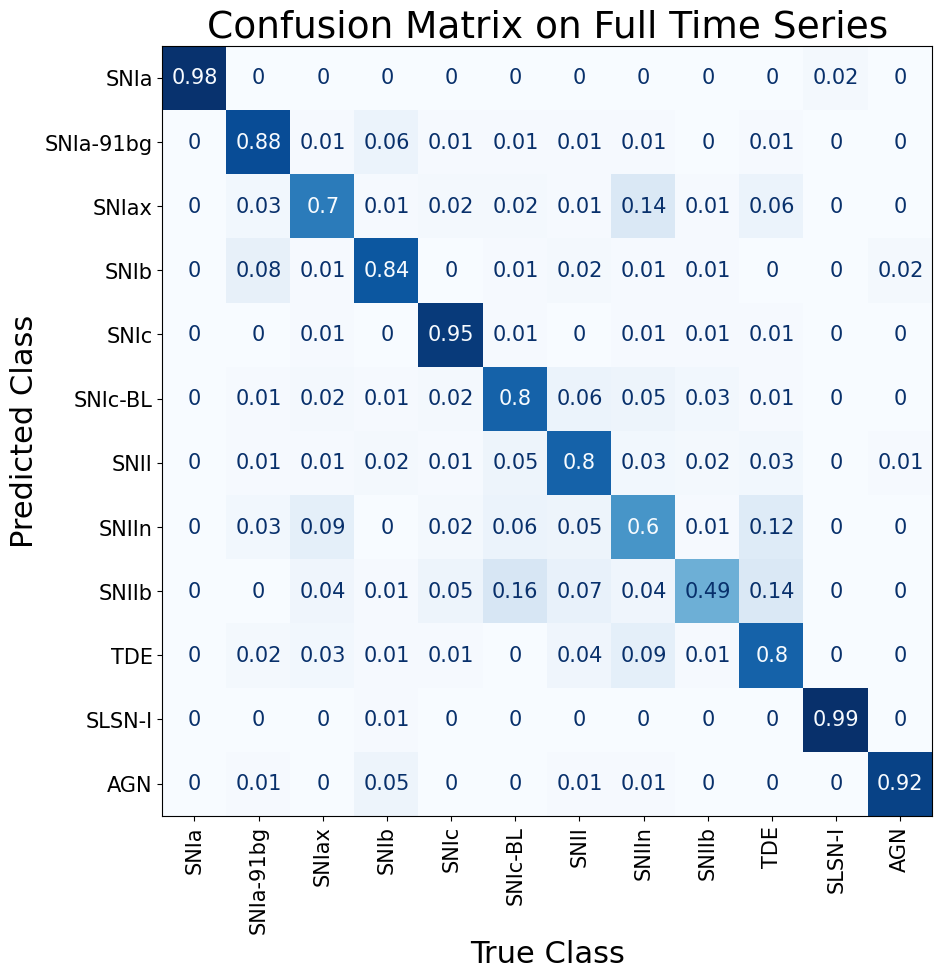

In [91]:
plot_confusion_matrix(best.test_predictions, y_test, savepath='FiguresNew/ConfusionMatrix')

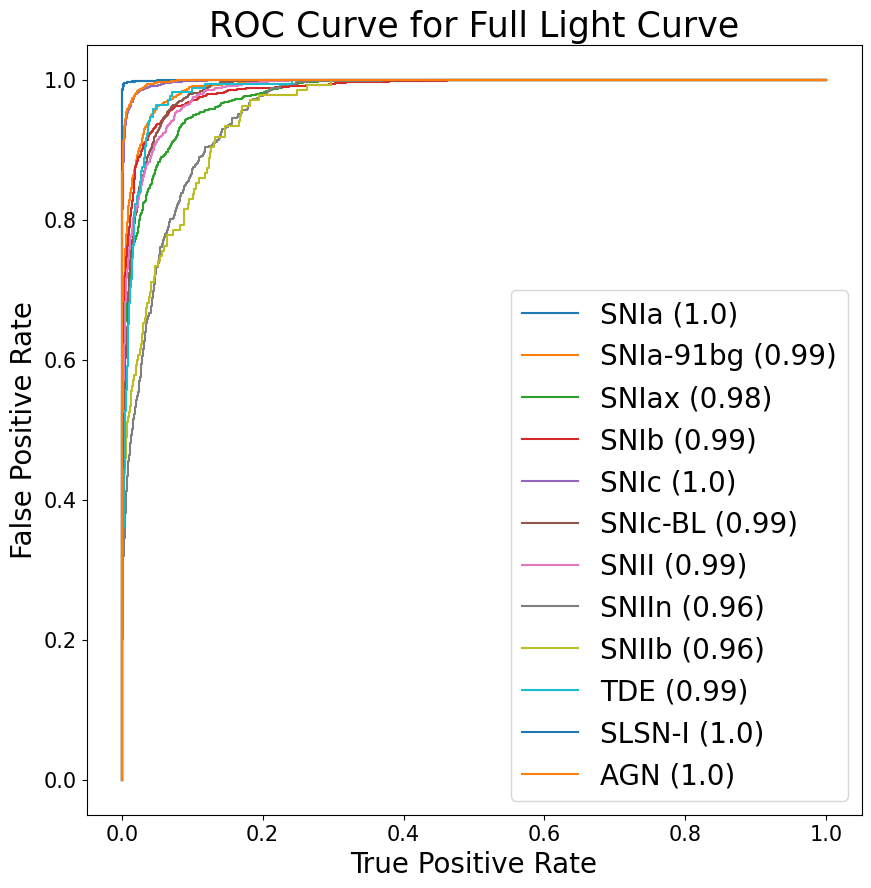

In [92]:
plot_roc_curve(best.test_predictions, y_test, savepath='FiguresNew/ROCCurve')

In [32]:
from sklearn.metrics import auc

def get_pr(minority, majority):

    precision = []
    recall = []
    thresholds = []
    minority=np.array(minority)
    majority=np.array(majority)
    for threshold in np.arange(min(np.min(minority),np.min(majority)), max(np.max(minority),np.max(majority)) + 0.002, 0.001):
        ta = np.count_nonzero(minority > threshold)
        fa = np.count_nonzero(majority > threshold)
        tn = np.count_nonzero(majority < threshold)
        fn = np.count_nonzero(minority < threshold)
        if fn == 0 or fa == 0:
          continue
        if (ta + fa == 0):
            continue
        recall.append(ta / (ta + fn))
        precision.append(ta / (ta + fa))
        thresholds.append(threshold)
    return thresholds, precision, recall

def get_pr_auc(scores_maj, y_data_maj, scores_anom, y_data_anom):
    np.random.seed(60)
    
    aucs = {}
    
    for ind, i in enumerate(non_anom_classes):
        
        mult_iso_maj_class = [scores_maj[t] for t in range(len(scores_maj)) if non_anom_classes[np.argmax(y_data_maj[t])] == i]

        mult_iso_min_cur = np.random.choice(scores_anom, int(len(mult_iso_maj_class)), p=p_anom)

        thresholds, precision, recall = get_pr(mult_iso_maj_class, mult_iso_min_cur)

        aucs[file_to_class[i]] = auc(recall, precision)


    for ind, i in enumerate(anom_classes):
        mult_iso_min_class = [scores_anom[t] for t in range(len(y_data_anom)) if y_data_anom[t] == i] # all anomalies of current class (i)

        mult_iso_min_class = np.random.choice(mult_iso_min_class, int(min(len(scores_maj), len(mult_iso_min_class))))

        thresholds, precision, recall = get_pr(mult_iso_min_class, scores_maj)

        aucs[file_to_class[i]] = auc(recall, precision)

        
    return aucs

In [39]:
import matplotlib.gridspec as gridspec

class_weights_anom = {i: 0 for i in anom_classes}

for i in y_data_anom:
  class_weights_anom[i]+=1

for i in list(class_weights_anom.keys()):
  class_weights_anom[i] = len(y_data_anom) / class_weights_anom[i]


p_anom = [class_weights_anom[i] for i in y_data_anom]

sum = np.sum(p_anom)

for i in range(len(p_anom)):
  p_anom[i] /= sum

def plot_pr_anom(scores_maj, y_data_maj, scores_anom, y_data_anom, s=None):
    
    fig = plt.figure(figsize=(18, 12))
    gs = gridspec.GridSpec(2, 3, width_ratios=[1,2,0], height_ratios=[1,1])

    ax3 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax3)
    ax = fig.add_subplot(gs[:, 1:3])

    ax.set_aspect('equal', 'box')
    
    plt.ylim((0, 1))
    plt.xlim((0, 1))

    for ind, i in enumerate(anom_classes):
        mult_iso_min_class = [scores_anom[t] for t in range(len(scores_anom)) if y_data_anom[t] == i] # all anomalies of current class (i)

        mult_iso_min_class = np.random.choice(mult_iso_min_class, int(min(len(scores_maj), len(mult_iso_min_class))))

        thresholds, precision, recall = get_pr(mult_iso_min_class, scores_maj)

        ax.plot(recall, precision, label=f"{file_to_class[i]} ({round(auc(recall, precision), 2)})", c = color[ind])

        ax2.plot(thresholds, recall, label=f"{file_to_class[i]}", c = color[ind])

        ax3.plot(thresholds, precision, label=f"{file_to_class[i]}", c = color[ind])

    # ax3.set_xlim(-0.13, 0.2)
    # ax2.set_ylim(0, 0.2)

    ax.set_ylabel("Precision", fontsize=22)
    ax.set_xlabel("Recall", fontsize=22)
    ax.legend(fontsize=18)

    ax2.set_ylabel("Recall", fontsize=22)
    ax2.set_xlabel("Threshold", fontsize=22)
    # ax2.legend(fontsize=15)

    ax3.set_ylabel("Precision", fontsize=22)
    ax3.set_xlabel("Threshold", fontsize=22)
    # ax3.legend(fontsize=15)

    fig.suptitle("Anomaly Precision-Recall Curve for Anomalous Classes", fontsize=30)



    # plt.savefig(f"{figpath}/PRAnomClassTesting.pdf", bbox_inches='tight')
    saveplot(s)

def plot_pr_maj(scores_maj, y_data_maj, scores_anom, y_data_anom, s=None):
    fig = plt.figure(figsize=(18, 12))
    gs = gridspec.GridSpec(2, 3, width_ratios=[1,2,0], height_ratios=[1,1])

    ax3 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax3)
    ax = fig.add_subplot(gs[:, 1:3])

    ax.set_aspect('equal', 'box')


    plt.ylim((0, 1))
    plt.xlim((0, 1))

    for ind, i in enumerate(non_anom_classes):

        mult_iso_maj_class = [scores_maj[t] for t in range(len(scores_maj)) if non_anom_classes[np.argmax(y_test[t])] == i]

        mult_iso_min_cur = np.random.choice(scores_anom, int(len(mult_iso_maj_class)), p=p_anom)

        thresholds, precision, recall = get_pr(mult_iso_maj_class, mult_iso_min_cur)

        ax.plot(recall, precision, label=f"{file_to_class[i]} ({round(auc(recall, precision), 2)})", c = color[ind])

        ax2.plot(thresholds, recall, label=f"{file_to_class[i]}", c = color[ind])

        ax3.plot(thresholds, precision, label=f"{file_to_class[i]}", c = color[ind])

    # ax3.set_xlim(-0.13, 0.17)
    # ax.set_xlim(0, 1)
    # ax.set_xlim(0, 0.2)

    ax.set_ylabel("Precision", fontsize=22)
    ax.set_xlabel("Recall", fontsize=22)
    ax.legend(fontsize=18)

    ax2.set_ylabel("Recall", fontsize=22)
    ax2.set_xlabel("Threshold", fontsize=22)
    # ax2.legend(fontsize=15)

    ax3.set_ylabel("Precision", fontsize=22)
    ax3.set_xlabel("Threshold", fontsize=22)
    # ax3.legend(fontsize=15)

    fig.suptitle("Anomaly Precision-Recall Curve for Majority Classes", fontsize=30)
   
    saveplot(s)


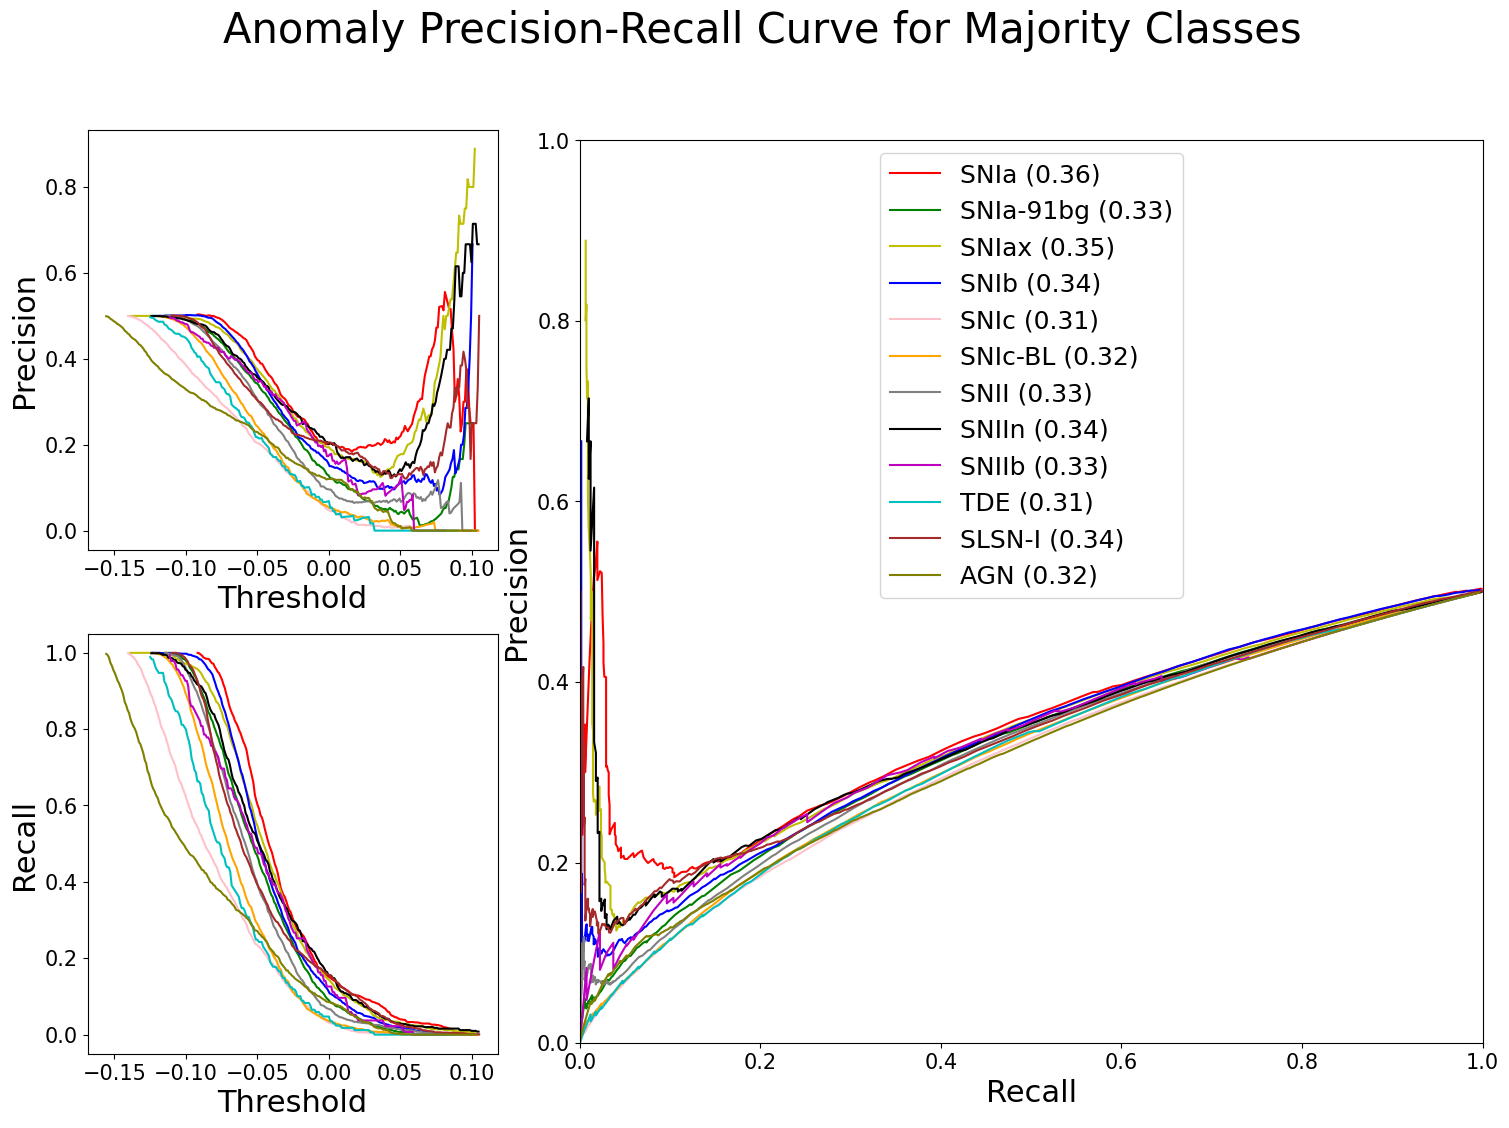

In [45]:
plot_pr_maj(best.test_scores, y_test, best.anom_scores, y_data_anom, s="FiguresNew/PRMaj")

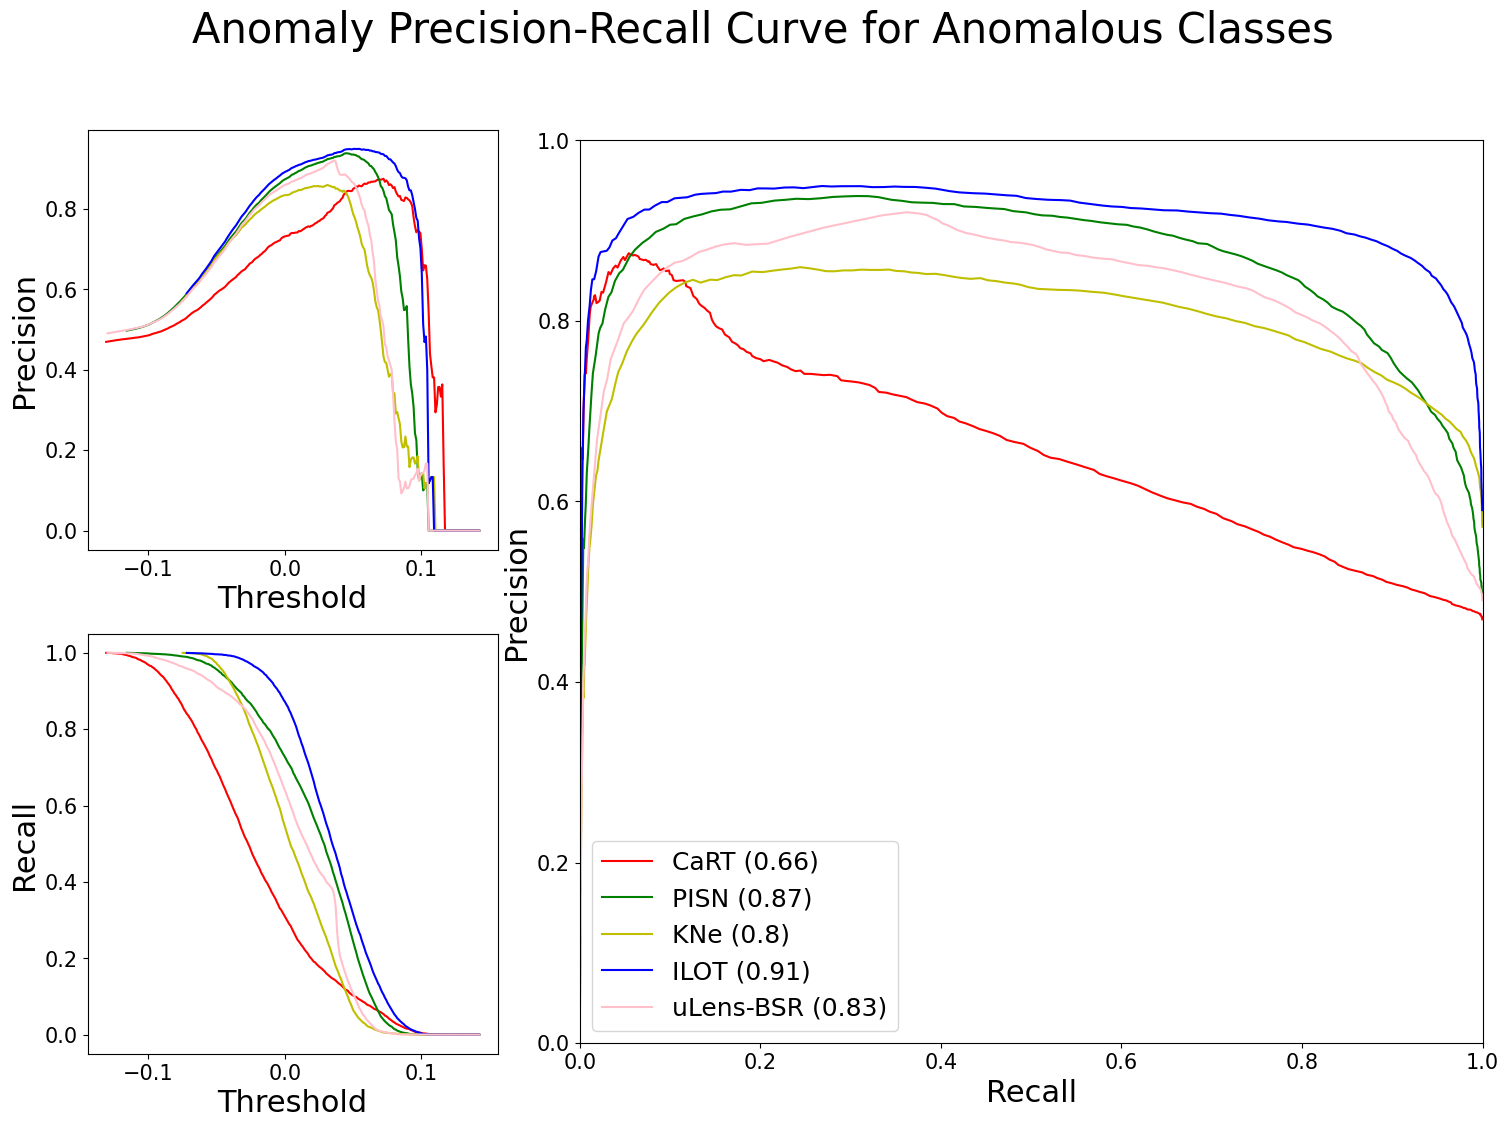

In [46]:
plot_pr_anom(best.test_scores, y_test, best.anom_scores, y_data_anom, s="FiguresNew/PRAnom")

377/377 [==============================] - 11s 29ms/step


In [97]:
import seaborn as sns


def plot_dist(scores_maj, y_data_maj, scores_anom, y_data_anom, title = 'Distribution of Anomaly Scores\n Supervised Isolation Forests', savepath=None):
    color = ['#ADD8E6'] * 12 + ['#FF6645'] * 5
    
    x=[]
    g=[]

    for i in range(len(scores_maj)):
        g.append(file_to_class[non_anom_classes[np.argmax(y_data_maj[i])]])
        x.append(scores_maj[i])

    for i in range(len(scores_anom)):
        g.append(file_to_class[y_data_anom[i]])
        x.append(scores_anom[i])

    df = pd.DataFrame(dict(x=x, g=g))

    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    # Initialize the FacetGrid object
    # pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=color)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "x",
          bw_adjust=.5, clip_on=False,
          fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

    # passing color=None to refline() uses the hue mapping, but we do color = 'blue'
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)


    g.map(label, "x")

    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.set(xlabel="Anomaly Score")

    g.despine(bottom=True, left=True)
    g.fig.suptitle(title, fontsize=23)

    if (savepath):
        g.figure.savefig(f"{savepath}.pdf", bbox_inches='tight')

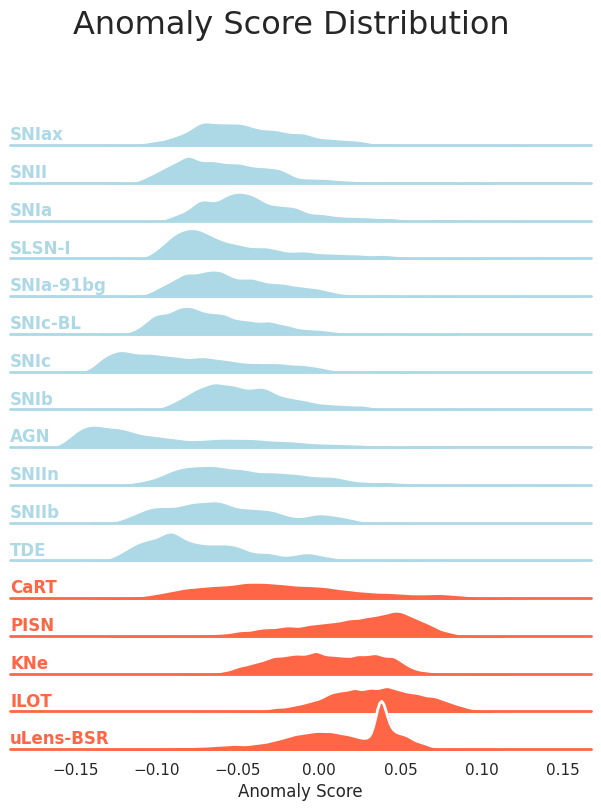

In [51]:
plot_dist(best.val_scores, y_val, best.anom_scores, y_data_anom, title=f"Anomaly Score Distribution", savepath=f'FiguresNew/Distribution')

In [38]:




def plot_recall(majority, minority, s=None, seed=60): # USE DEFAULT SEED!
    np.random.seed(seed)

    k = 20

    pref_counts = {}
    
    for key in ['All'] + anom_classes:
        pref_counts[key] = []
    
    

    

    for _ in range(k):

      random_sample_maj = majority
    
      min_mask = np.random.choice(range(len(minority)), int(len(majority)/220), p = p_anom)
      random_sample_min = np.array(minority)[min_mask]
      min_classes = np.array(y_data_anom)[min_mask]
        
      # print(random_sample_min)

      full_sample = [(i, 0) for i in random_sample_maj] + [(i, min_classes[ind]) for ind, i in enumerate((random_sample_min))]
      full_sample = list(reversed(sorted(full_sample)))

      pref_sample = {i : [0] for i in anom_classes}
      pref_sample['All'] = [0]
      for i in full_sample:
        pref_sample['All'].append(pref_sample['All'][-1] + (i[1] != 0))
        
        for key in anom_classes:
           pref_sample[key].append(pref_sample[key][-1] + (i[1] == key))
            
        
      for key in pref_sample.keys():
          pref_counts[key].append(pref_sample[key])
            
    final = []
            
    for key, value in pref_counts.items():
      med = []
      dev = []
        
        
      pref_counts = np.array(value).T

      for i in range(len(pref_counts)):
        pref_counts[i] = np.array(pref_counts[i])

        med.append(np.mean(pref_counts[i]))
        dev.append(np.std(pref_counts[i]))


      recall = np.array(med)/int(len(majority)/220)
      med=np.array(med)
      dev = np.array(dev)
    
      final.append([med, dev, key])
    
    
    fig, ax = plt.subplots()

    font = {'size'   : 17}

    matplotlib.rc('font', **font)

    ax.set_xlim(0, 2000)
    ax.set_xlabel("Index (Top 2000 Scores)", fontsize=18)
    # ax.set_ylabel("Recall", fontsize=18)

    ax.set_title("Anomalies Detected by Index", fontsize=21)

    ax2 = ax.twinx()

    ax2.set_ylabel('Detected Anomalies', fontsize=16)
    
    for med, dev, label in final:
        if (label == 'All'):
            continue
        ax2.plot(med, label=file_to_class[label] if label != 'All' else 'This Work')
        ax2.fill_between(range(1, len(med) + 1), med + dev, med-dev, alpha = 0.2)
        
    x = np.array(range(0,2000))
    y = 1/220 * x
    plt.plot(x, y, label='Guessing')
    
    ax.set_yticks([])
    ax2.tick_params(axis='y')
    
    plt.legend(fontsize=14)

    plt.tight_layout()

    saveplot(s)

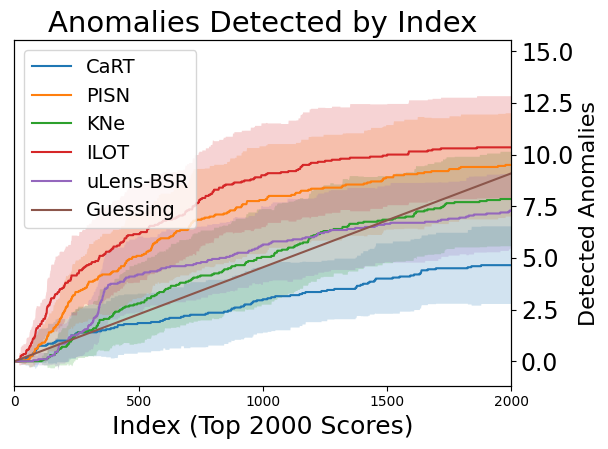

In [62]:
plt.style.use('default')
plot_recall(best.test_scores, best.anom_scores, s='FiguresNew/AnomByIndPer')


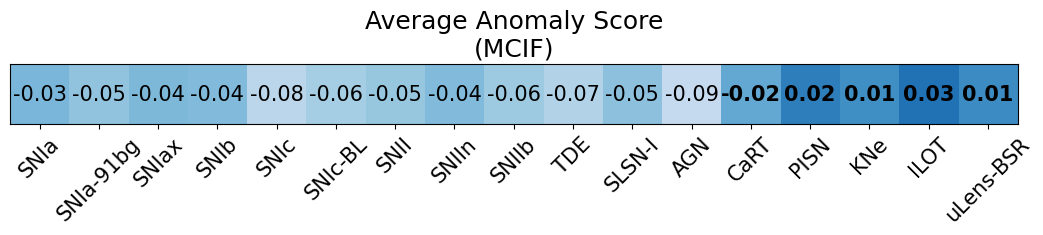

In [35]:
# for best in red:
average_score(best.val_scores, y_val, best.anom_scores, y_data_anom, title=f"Average Anomaly Score\n(MCIF)", savepath=f'FiguresNew/AverageScoreRedo')



In [74]:
def plot_history(model, s= None):
    ins = 'No' if not model.redshift else ''
    
    hist = load(f'Models/{ins}RedshiftLatent_{model.size}_history')
    
    plt.plot(range(1, len(hist.history['val_loss']) + 1), hist.history['val_loss'], label='Validation Loss')
    plt.plot(range(1, len(hist.history['loss']) + 1), np.array(hist.history['loss']) * len(X_val) /  len(X_train), label='Training Loss')
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    
    plt.legend()
    
    plt.title('Training/Validation Loss', fontsize=19)
    saveplot(s)

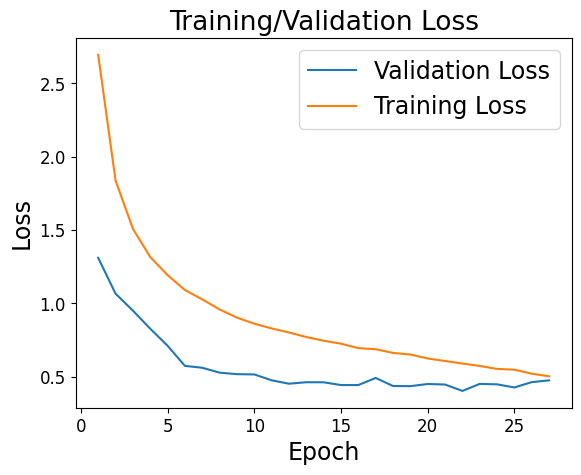

In [75]:
plot_history(best, s = 'FiguresNew/LossHistory')

In [74]:
color = ['r', 'g', 'y', 'b', 'pink', 'orange', 'gray', 'k', 'm', 'c', 'brown', 'olive']

def get_reducer(data):
    reducer = umap.UMAP(random_state=5, min_dist=0.5, n_neighbors=500)

    reducer.fit(data)
    
    embedding=reducer.transform(data)
    
    return reducer, embedding
    
def plot_umap(embedding, labels, legend, title='', savepath='', color=color):
    plt.figure(figsize=(10, 10))
    for cc, i in enumerate(np.unique(labels)):
        
        e=[]
        for ind, point in enumerate(labels):
            # print(point)
            if point == i:
                e.append(embedding[ind])
        
        # print(np.unique(labels))
        # print(cc, e)
        assert(not len(e) == 0)
        e = np.array(e)
        plt.scatter(e[:, 0], e[:, 1], label=legend[cc], c=color[cc] if cc != 0 else 'grey')
        
        
    plt.title(title, fontsize=22)
    plt.xlabel('Arbritary Units')
    plt.ylabel('Arbritary Units')
    plt.legend(fontsize=14)
    saveplot(savepath)
    
    # return reducer

In [ ]:
!pip install \
    --extra-index-url=https://pypi.nvidia.com \
    cudf-cu12 dask-cudf-cu12 cuml-cu12 cugraph-cu12 cuspatial-cu12 \
    cuproj-cu12 cuxfilter-cu12 cucim pylibraft-cu12 raft-dask-cu12

In [81]:
import umap
best.te_reducer, best.te_embedding = get_reducer(best.test_latent)

NumbaRuntimeError: Failed in nopython mode pipeline (step: nopython frontend)
compiler re-entrant to the same function signature

In [ ]:
best.tr_reducer, best.tr_embedding = get_reducer(best.train_latent)
best.a_reducer, best.a_embedding = get_reducer(best.anom_latent)
# best.te_reducer, best.te_embedding = get_reducer(best.test_latent)

In [ ]:
save("NewFinal", best)

In [ ]:
plot_umap(best.tr_embedding, [np.argmax(i) for i in y_train], ordered_class_names, title = "UMAP Reduction on Training Data", savepath="FiguresNew/UMAPTrain")

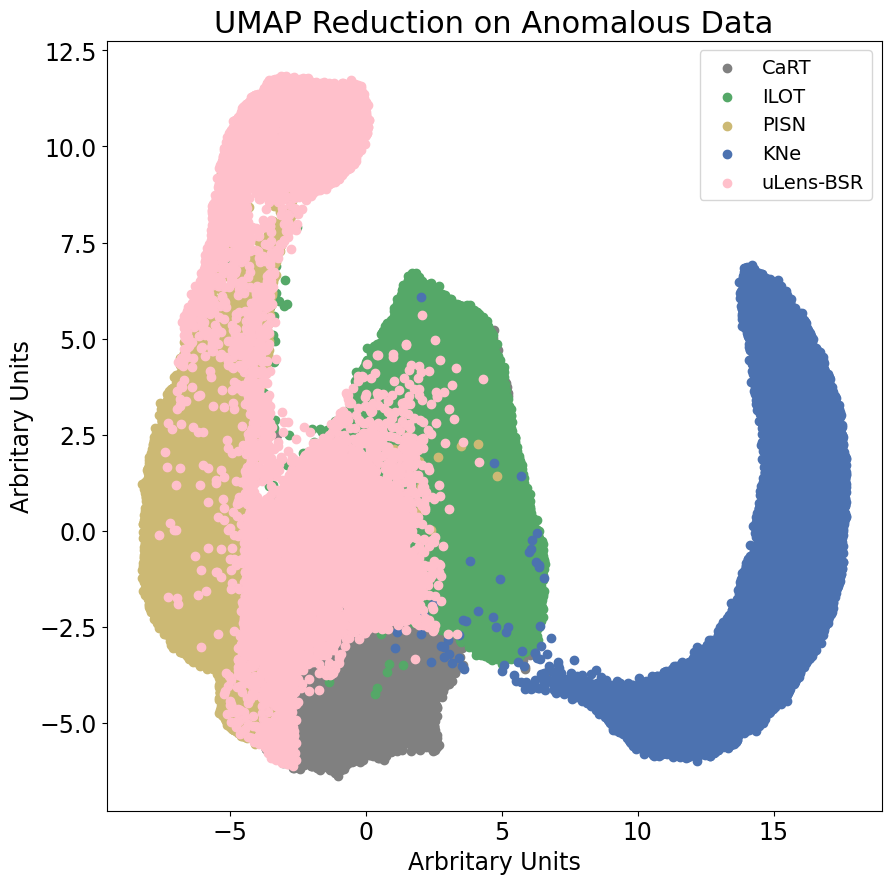

In [81]:
plot_umap(best.a_embedding, y_data_anom, [file_to_class[i] for i in np.unique(y_data_anom)], title="UMAP Reduction on Anomalous Data", savepath="FiguresNew/UMAPAnom")

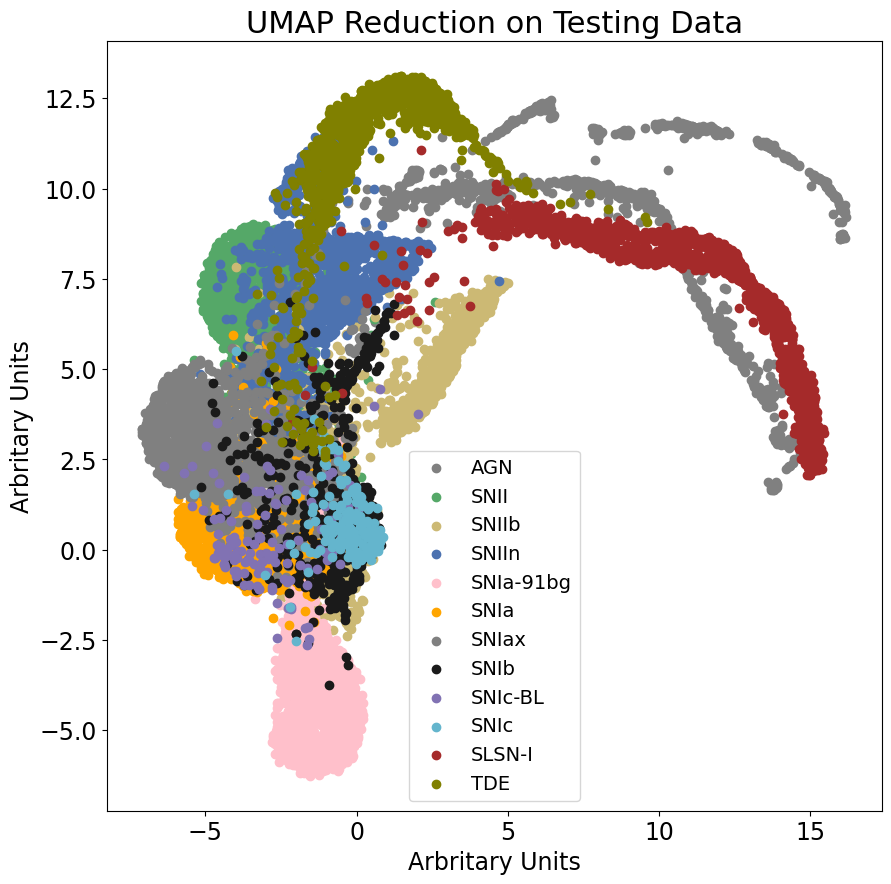

In [89]:
plot_umap(best.te_embedding, [np.argmax(i) for i in y_test], ordered_class_names, title="UMAP Reduction on Testing Data", savepath="FiguresNew/UMAPTest")

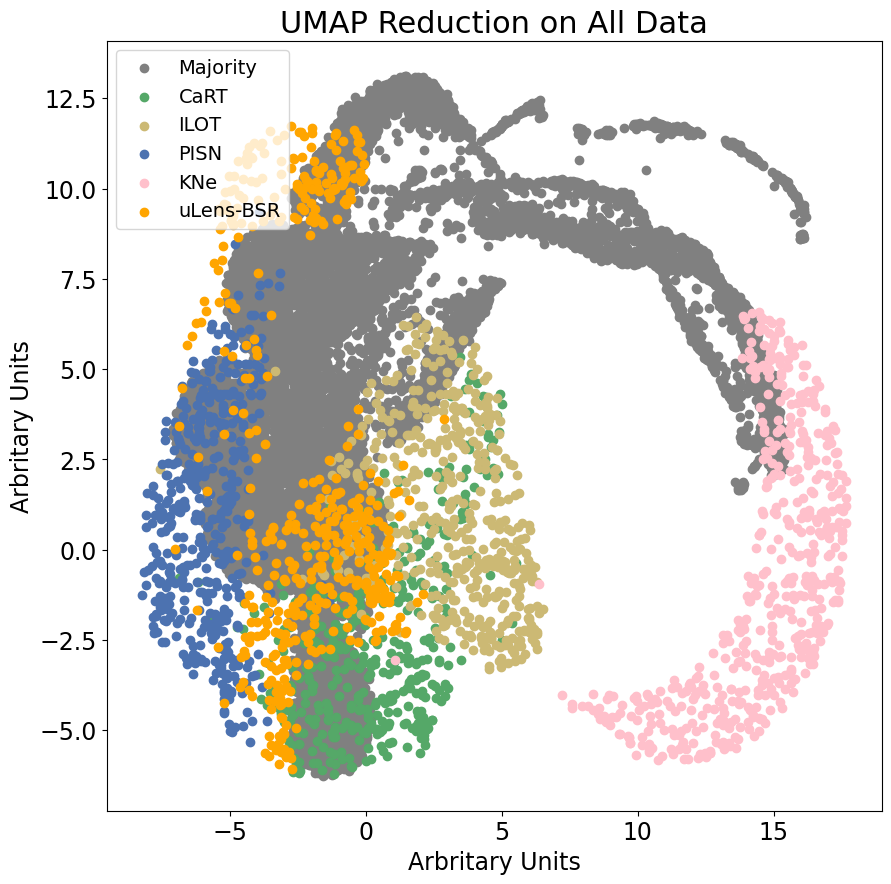

In [90]:
idx = np.random.choice(np.arange(len(best.a_embedding)), round(len(best.te_embedding)/5), replace=False)
vals = best.a_embedding[idx]
labels = np.array(y_data_anom)[idx]

plot_umap(np.append(best.te_embedding, vals, axis=0), ['Majority' for i in y_test] + list(labels), ['Majority'] + [file_to_class[i] for i in np.unique(labels)], title="UMAP Reduction on All Data", savepath="FiguresNew/UMAPAll")

In [ ]:
save("NewFinal", best)

In [44]:
def cut_curve(lc, cutoff, ind=False): # assumes scaled cutoff
  # print(lc.shape)
  lo = 0
  hi = len(lc)-1

  while (lo < hi):
    m = (lo + hi)//2
    # print(lc[m][1], cutoff)
    if (lc[m][1] > cutoff or lc[m][1] == 0):
      hi = m
    else:
      lo = m+1

  # print(lo)
  for i in range(hi, len(lc)):
    if (not np.any(lc[i])):
      break

    lc[i] = np.zeros(4)

  if (not ind):
    return lc
  else:
    return hi

In [59]:
# Real Time Results

p_norm = [class_weights[np.argmax(i)] for i in y_test]

sum = np.sum(p_norm)

for i in range(len(p_norm)):
  p_norm[i] /= sum


def get_anomaly_real_time(curves, host_galaxy, inds, model):

    splits = []
    lcs = []
    host_gals = []
    for ind in inds:
        cur = np.zeros((ntimesteps, 4))
        anomaly_scores = []
        host_gal = np.array(host_galaxy[ind])
        curve = curves[ind]
        
        for ind, i in enumerate(curve):
            if (np.count_nonzero(i) == 0):
                break
            cur[ind]=i

            lcs.append(cur.copy())
            host_gals.append(host_gal)
    
        splits.append(len(lcs))

    lcs = np.array(lcs)
    host_gals = np.array(host_gals)

    scores = model.score(model.latent_model.predict([np.array(lcs), np.array(host_gals)]))
    
    ans = []
    prv=0
    for diff in splits:
        ans.append(scores[prv:diff])
        prv=diff
    return ans

def plot_real_median(X_test, x_data_anom, model, savepath=""):
    
    # assert(len(norm_scores) == len(anom_scores) and len(norm_scores) == 200)
    
    norm_median = []
    norm_deviation = []
    
    


    cutoffs = list(range(-30, 75, 5))

    for t in cutoffs:

      cur_values = []
      for ind in range(len(normal_inds)):

        cutoff = cut_curve(np.copy(X_test[normal_inds[ind]]), (t+30)/100, ind=True)

        if (X_test[normal_inds[ind]][cutoff][1] <= (t+30-5)/100):
          continue
        cur_values.append(norm_scores[ind][min(cutoff, len(norm_scores[ind])-1)])



      cur_values=np.array(cur_values)

      norm_median.append(np.median(cur_values))
      norm_deviation.append(np.median(np.absolute(cur_values - np.median(cur_values))))

    norm_median = np.array(norm_median)
    norm_deviation = np.array(norm_deviation)

    fig, ax = plt.subplots(figsize=(8, 8))

    maj_col = u'#1f77b4'
    ax.plot(cutoffs, norm_median, '-', label="Majority", color=maj_col)
    ax.fill_between(cutoffs, norm_median - norm_deviation, norm_median + norm_deviation, alpha=0.2, color=maj_col)
    ax.plot(cutoffs, norm_median, 'o', color=maj_col)


    anom_median = []
    anom_deviation = []

    class_median = {i: [] for i in anom_classes}
    class_deviation = {i: [] for i in anom_classes}

    for t in cutoffs:

      cur_values = []
      cur_class = {i : [] for i in anom_classes}
      for ind in range(len(anom_inds)):
        cutoff = cut_curve(np.copy(x_data_anom[anom_inds[ind]]), (t+30)/100, ind=True)
        if (x_data_anom[anom_inds[ind]][cutoff][1] <= (t+30-5)/100):
          continue

        cur_values.append(anom_scores[ind][min(cutoff, len(anom_scores[ind])-1)])
        
        cur_class[y_data_anom[anom_inds[ind]]].append(anom_scores[ind][min(cutoff, len(anom_scores[ind])-1)])
      
      for c in anom_classes:
        cur_class[c] = np.array(cur_class[c])
        class_median[c].append(np.median(cur_class[c]))
        class_deviation[c].append(np.median(np.absolute(cur_class[c] - np.median(cur_class[c]))))

      cur_values=np.array(cur_values)

      anom_median.append(np.median(cur_values))
      anom_deviation.append(np.median(np.absolute(cur_values - np.median(cur_values))))

    anom_median = np.array(anom_median)
    anom_deviation = np.array(anom_deviation)

    ax.plot(cutoffs, anom_median, '-', label="All Anomalous", color=u'#ff7f0e')
    ax.fill_between(cutoffs, anom_median - anom_deviation, anom_median + anom_deviation, alpha=0.2, color=u'#ff7f0e')
    ax.plot(cutoffs, anom_median, 'o', color=u'#ff7f0e')
    
    # for ind, c in enumerate(anom_classes):
    #     ax.plot(cutoffs, class_median[c], '-', label=file_to_class[c], color=color[ind])
    #     # print(class_mdian[c])
    #     ax.fill_between(cutoffs, np.array(class_median[c]) - np.array(class_deviation[c]), np.array(class_median[c]) + np.array(class_deviation[c]), alpha=0.2, color=color[ind])
    #     ax.plot(cutoffs, class_median[c], 'o', color = color[ind])

    ax.set_xlabel("Time", fontsize=25)
    ax.set_ylabel("Anomaly Score", fontsize=25)
    ax.legend(fontsize=20)

    ax.set_title("Median Anomaly Score Over Time", fontsize=28)
    
    saveplot(savepath)

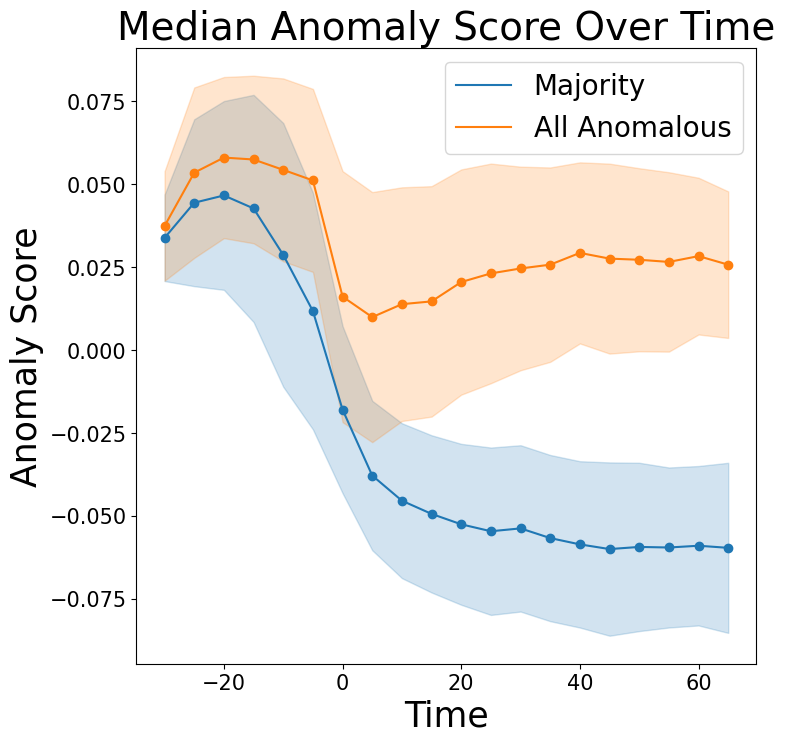

In [60]:

plot_real_median(X_test, x_data_anom, best, "FiguresNew/OverTimeAll")

In [41]:
normal_inds = np.random.choice(list(range(len(X_test))), 1000, p=p_norm, replace=False)
anom_inds = np.random.choice(list(range(len(x_data_anom))), 1000, p = p_anom, replace=False)

norm_scores = get_anomaly_real_time(X_test_redshift, host_gal_test, normal_inds, best)

anom_scores = get_anomaly_real_time(X_anom_redshift, host_gal_anom, anom_inds, best)

1279/1279 [==============================] - 7s 5ms/step


In [59]:
file_to_class.values()

dict_values(['SNIa', 'SNIa-91bg', 'SNIax', 'SNIb', 'SNIc', 'SNIc-BL', 'SNII', 'SNIIn', 'SNIIb', 'TDE', 'SLSN-I', 'AGN', 'CaRT', 'PISN', 'KNe', 'ILOT', 'uLens-BSR'])

In [ ]:

from sklearn.preprocessing import MinMaxScaler

# fig, axs = plt.subplots(1, 2, figsize=(20, 30), sharey=True)
# fig.subplots_adjust(hspace=0)


done = {i : False for i in file_names}

def plot_curves(name, num = 100):

    band_medians = {'r' : 0.4827, 'g' : 0.6223}
    cnt = 0

    for ind in range(len(x_data)):

        if (target[ind] == name and cut_curve(x_data[ind], 1, ind=True) > 55 and host_galaxy_info[ind][0] < 0.5):
            
            maxi = np.max(x_data[ind][:, 2])
            mini = np.min(x_data[ind][:, 2])
            x_data[ind][:, 2] = (x_data[ind][:, 2] - mini) / (maxi - mini)
            x_data[ind][:, 3] /= (maxi - mini)

            done[target[ind]] = True
            cnt += 1


            red = x_data[ind][x_data[ind][:, 0] == band_medians['r']]
            green = x_data[ind][x_data[ind][:, 0] == band_medians['g']]
            plt.errorbar(red[:, 1], ((red[:, 2] + 30) * 100) / (1 + host_gal[ind]), fmt='^', alpha=0.3, color = colors[file_names.index(target[ind]) % len(colors)])
            plt.errorbar(green[:, 1], ((green[:, 2] + 30) * 100)  / (1 + host_gal[ind]), fmt='o', alpha=1, color = colors[file_names.index(target[ind])  % len(colors)])

            # axs[int(cnt > 8)].errorbar(new_vals[:, 1] * 100 - 30, new_vals[:, 2] + prv_mx, fmt='o', color = colors[file_names.index(target[ind]) % len(colors)])
            # plt.text(0, prv_mx + x_data[0][2] + 0.5, file_to_class[target[ind]], fontsize=20, color = colors[file_names.index(target[ind]) % len(colors)])

            # prv_mx += np.max(new_vals[:, 2]) + 0.5
            
            plt.ylabel('Scaled Flux + Offset', fontsize=15)
            plt.xlabel('Time Since Trigger', fontsize=15)
            plt.title(str(ind))
            
            plt.show()

        if (cnt == 100):
            break
    
    # plt.title('Sample Light Curves')
    # plt.ylim(-1, 29)
    # saveplot("Figures/samplecurves")
    
plot_curves(class_to_file['uLens-BSR'])

In [ ]:
interesting_inds = [6, 13024, 26037, 39092, 44415, 45914, 47312, 60322, 73318, 85658, 97110, 114369, 120846, 130758, 144661, 153253, 164107]

In [47]:
class_to_file = {v: k for k, v in file_to_class.items()}

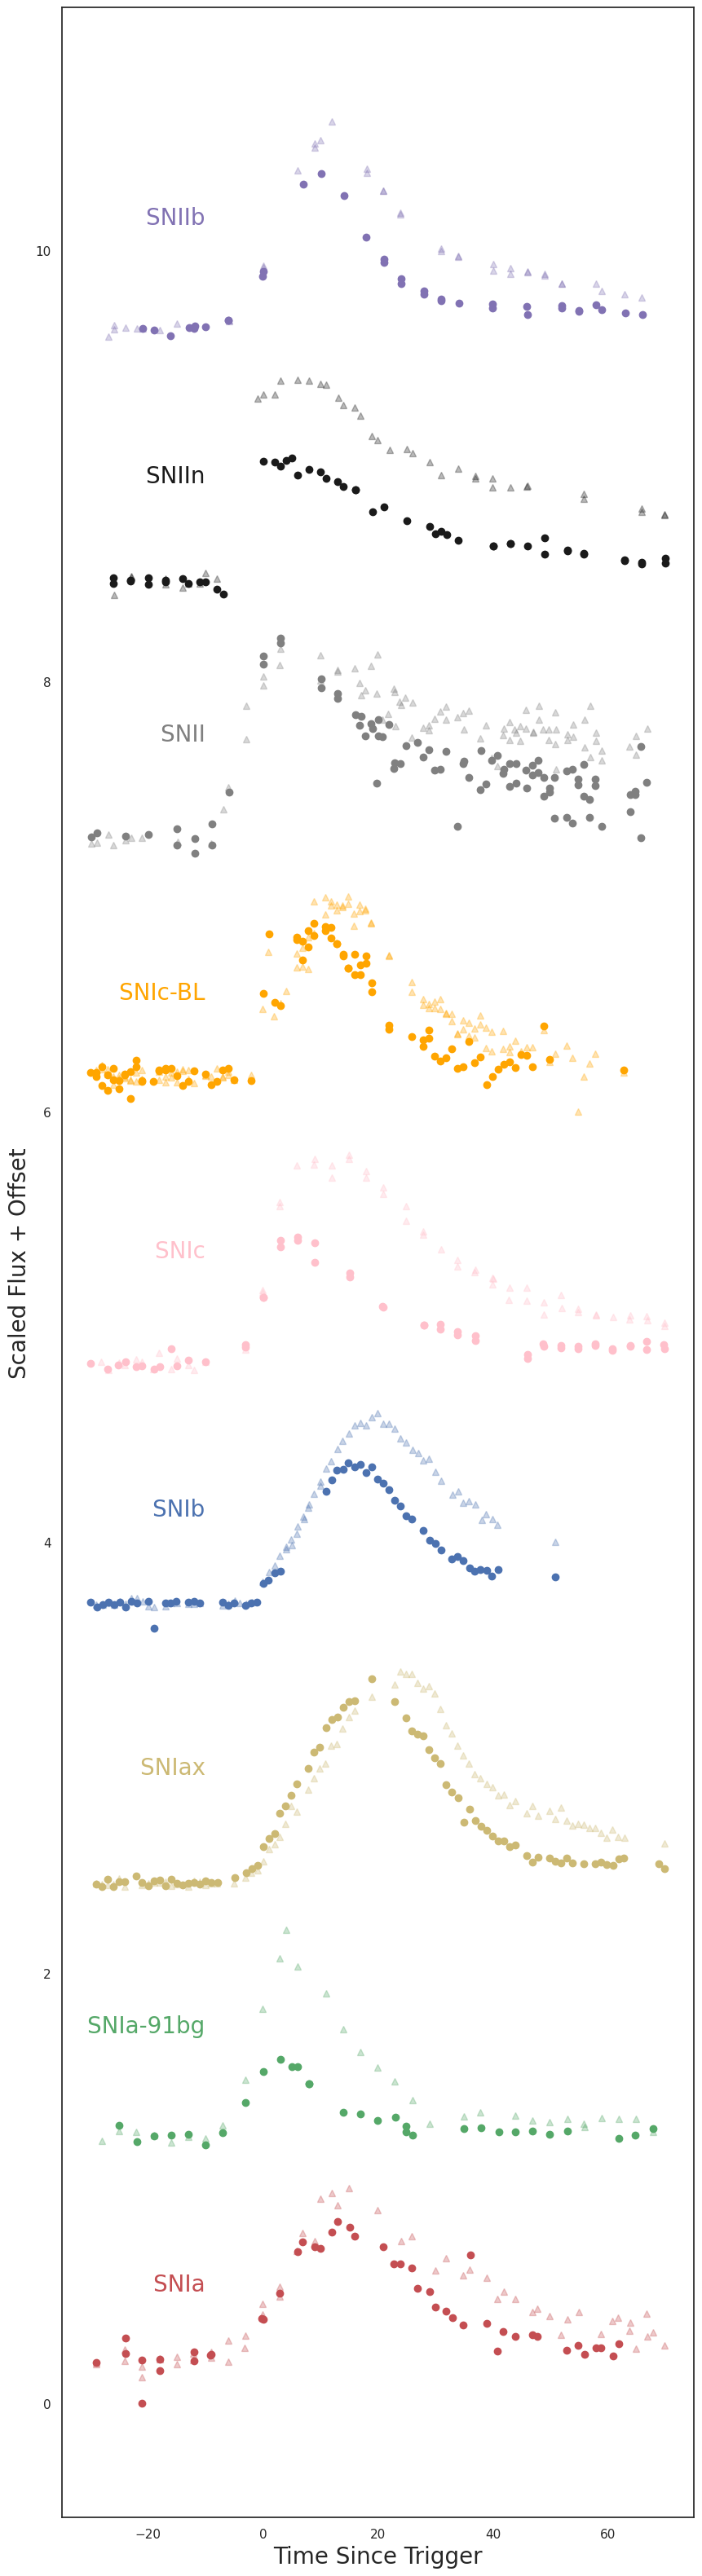

In [104]:

from sklearn.preprocessing import MinMaxScaler


plt.figure(figsize=(10, 40))
# fig, axs = plt.subplots(1, 2, figsize=(20, 30), sharey=True)
# fig.subplots_adjust(hspace=0)


done = {i : False for i in file_names}



band_medians = {'r' : 0.4827, 'g' : 0.6223}
prv_mx = 0
cnt = 0

for ind in [6, 13024, 26037, 39092, 44415, 45914, 47312, 60322, 73318, 85658, 97110, 114369, 120846, 130758, 144661, 153253, 164107]:

    maxi = np.max(x_data[ind][:, 2])
    mini = np.min(x_data[ind][:, 2])
    x_data[ind][:, 2] = (x_data[ind][:, 2] - mini) / (maxi - mini)
    x_data[ind][:, 3] /= (maxi - mini)

    done[target[ind]] = True
    cnt += 1
    if (cnt == 10):
        break

    red = x_data[ind][x_data[ind][:, 0] == band_medians['r']]
    green = x_data[ind][x_data[ind][:, 0] == band_medians['g']]
    plt.errorbar((red[:, 1]) * 100 - 30, red[:, 2] + prv_mx, fmt='^', alpha=0.3, color = colors[file_names.index(target[ind]) % len(colors)])
    plt.errorbar((green[:, 1]) * 100 - 30, green[:, 2] + prv_mx, fmt='o', alpha=1, color = colors[file_names.index(target[ind])  % len(colors)])

    # axs[int(cnt > 8)].errorbar(new_vals[:, 1] * 100 - 30, new_vals[:, 2] + prv_mx, fmt='o', color = colors[file_names.index(target[ind]) % len(colors)])
    plt.text(0, prv_mx + 0.5, file_to_class[target[ind]] + "        ", fontsize=20, color = colors[file_names.index(target[ind]) % len(colors)], ha='right', va='bottom')

    prv_mx += 1.2

        
plt.ylabel('Scaled Flux + Offset', fontsize=20)
plt.xlabel('Time Since Trigger', fontsize=20)

# plt.title('Sample Light Curves')
# plt.ylim(-1, 29)
saveplot("FiguresNew/samplecurves2")

In [93]:
class_weights = {i : 0 for i in range(y_train.shape[1])}

for value in y_train:
  class_weights[np.argmax(value)]+=1

for id in class_weights.keys():
  class_weights[id] = len(y_train) / class_weights[id]

sample_weights = [class_weights[np.argmax(i)] for i in y_train]

from sklearn.ensemble import IsolationForest

best.iforest = IsolationForest(random_state=0, max_samples = 'auto', n_estimators=200).fit(best.train_latent, sample_weight=sample_weights)



In [94]:
best.single_scores = -best.iforest.decision_function(best.test_latent)
best.single_scores_anom = -best.iforest.decision_function(best.anom_latent)

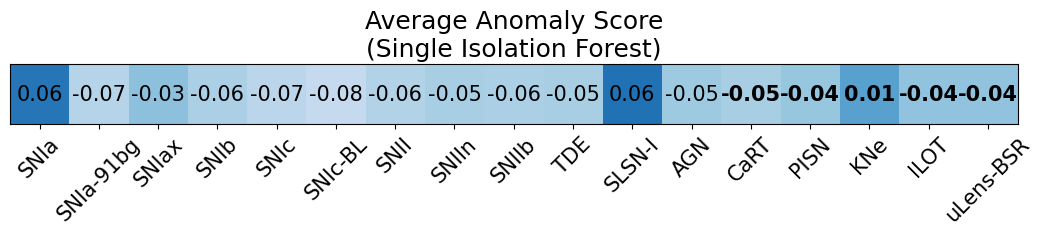

In [95]:
average_score(best.single_scores, y_test, best.single_scores_anom, y_data_anom, title="Average Anomaly Score\n(Single Isolation Forest)", savepath="FiguresNew/AverageScoreSingle")

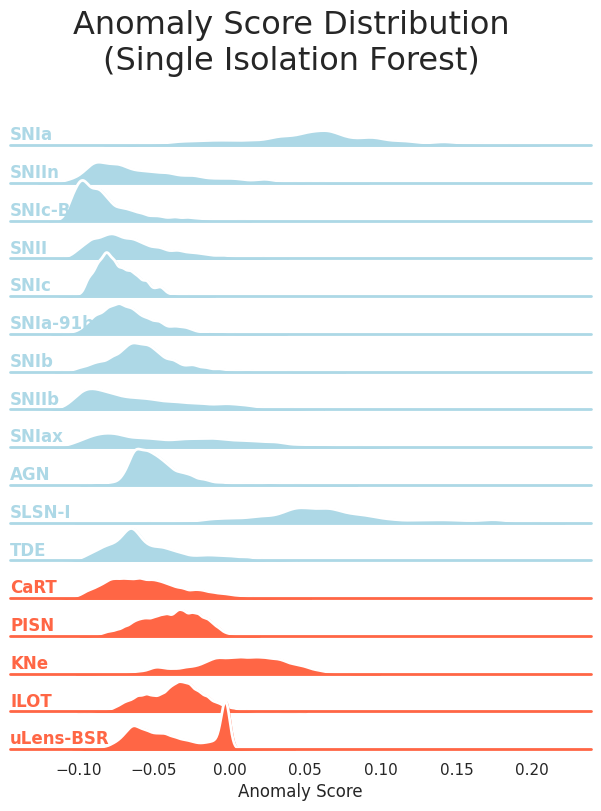

In [98]:
plot_dist(best.single_scores, y_test, best.single_scores_anom, y_data_anom, title="Anomaly Score Distribution\n(Single Isolation Forest)", savepath="FiguresNew/ScoreDistSingle")

In [99]:
import random, time
times = []

for _ in range(10):
  ind = random.randint(0, len(X_test_redshift))
  start_time = time.time()
  pred = best.latent_model.predict([np.array([X_test_redshift[ind]]), np.array([host_gal_test[ind]])], verbose=0)

  score = best.score(pred[0].reshape(1, -1))
  end_time = time.time()
  times.append(1000*(end_time - start_time))

In [100]:
print(np.mean(times))

1400.8798122406006
